('Datasets:', 'full:', (1309, 12), 'titanic:', (891, 12))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


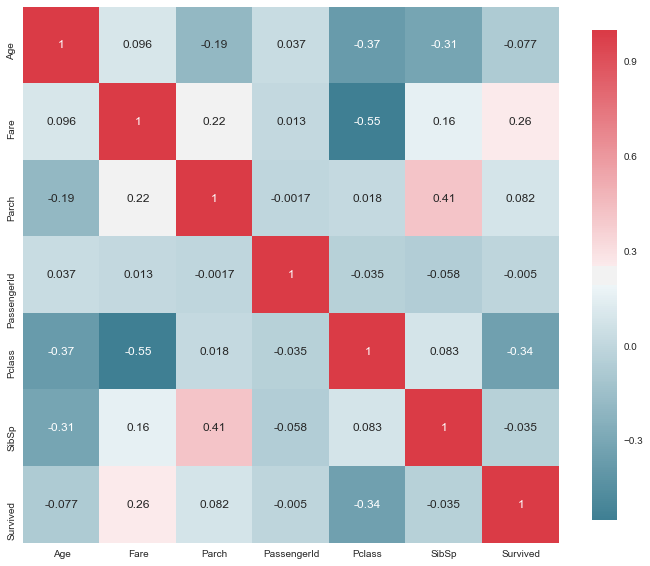

In [60]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
# Configure visualisations
#%matplotlib inline
#mpl.style.use( 'ggplot' )
#sns.set_style( 'white' )
#Visualization
#import seaborn as sns
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import matplotlib.pylab as pylab
#pylab.rcParams['figure.figsize'] = 8,6 # Big graphs unless specified
sns.set(color_codes=True) # Set style and color of graphs

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
train = pd.read_csv("/Users/houzhuo/Downloads/train.csv")
test    = pd.read_csv("/Users/houzhuo/Downloads/test.csv")
full = train.append(test,ignore_index=True)
titanic = full[:891]
print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)
full.info()
plot_correlation_map(full)

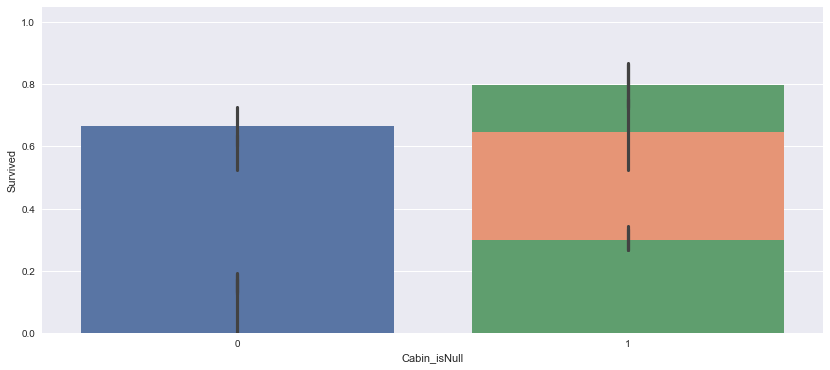

In [61]:
#Title
title = pd.DataFrame()
full['Title'] = full['Name'].map(lambda name:name.split(',')[1].split( '.' )[0].strip())
plt.figure(figsize=(14,6))
sns.barplot('Title', 'Survived', data=full)
#plt.show()
full['Title'] = full['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
full['Title'] = full['Title'].replace(['Mlle','Ms'], 'Miss')
full['Title'] = full['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
title = pd.get_dummies(full['Title'],prefix='Title')
full = pd.concat([full,title],axis=1)
sns.barplot('Title', 'Survived', data=full)

#Age & isChild
group = full.groupby(['Sex','Title', 'Pclass'])['Age']
full['Age'] = group.transform(lambda x: x.fillna(x.median()))
full['IsChild'] = np.where(full['Age']<=12,1,0)
full['IsOld'] = np.where(full['Age']>=63,1,0)

#Dead_female_family & Survive_male_family
full['Surname'] = full['Name'].apply(lambda x:x.split(',')[0])
dead_female_surname = list(set(full[(full.Sex=='female') & (full.Age>=12)
                              & (full.Survived==0) & ((full.Parch>0) | (full.SibSp > 0))]['Surname'].values))
survive_male_surname = list(set(full[(full.Sex=='male') & (full.Age>=12)
                              & (full.Survived==1) & ((full.Parch>0) | (full.SibSp > 0))]['Surname'].values))
full['Dead_female_family'] = np.where(full['Surname'].isin(dead_female_surname),0,1)
full['Survive_male_family'] = np.where(full['Surname'].isin(survive_male_surname),0,1)
#full = full.drop(['Name','Surname'],axis=1)

#FamilySize
full['FamilySize'] = np.where(full['SibSp']+full['Parch']==0, 'Alone',
                                    np.where(full['SibSp']+full['Parch']<=3, 'Small', 'Big'))
sns.barplot('FamilySize', 'Survived', data=full)
df = pd.get_dummies(full['FamilySize'],prefix='FamilySize')
full = pd.concat([full,df],axis=1).drop(['SibSp','Parch','FamilySize'],axis=1)

#Ticket_letter
full['Ticket_Lett'] = full['Ticket'].apply(lambda x: str(x)[0])
full['Ticket_Lett'] = full['Ticket_Lett'].apply(lambda x: str(x))
sns.barplot('Ticket_Lett', 'Survived', data=full)
full['High_Survival_Ticket'] = np.where(full['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
full['Low_Survival_Ticket'] = np.where(full['Ticket_Lett'].isin(['A','W','3','7']),1,0)
#full = full.drop(['Ticket','Ticket_Lett'],axis=1)

#Embarked
#full = full.drop('Embarked',axis=1)
full['Embarked_isC'] = np.where(full['Embarked']=='C',1,0)
#sns.barplot('Embarked_isC','Survived',data=full)

#Cabin
full[ 'Cabin' ] = full.Cabin.fillna( 'U' )
full['Cabin_isNull'] = np.where(full['Cabin']=='U',1,0)
sns.barplot('Cabin_isNull','Survived',data=full)
full = full.drop('Cabin',axis=1)

#PClass
df = pd.get_dummies(full['Pclass'],prefix='Pclass')
full = pd.concat([full,df],axis=1).drop('Pclass',axis=1)

#Sex
full['Sex'] = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

#Fare
full['Fare'].fillna(full['Fare'].dropna().median(),inplace=True)
full['Low_Fare'] = np.where(full['Fare']<=8.66,1,0)
full['High_Fare'] = np.where(full['Fare']>=26,1,0)

In [62]:
full_X = full
full_X = full_X.drop('PassengerId',axis=1)
full_X = full_X.drop('Survived',axis=1)
full_X = full_X.drop('Embarked',axis=1)
full_X = full_X.drop('Age',axis=1)
full_X = full_X.drop('Name',axis=1)
full_X = full_X.drop('Surname',axis=1)
full_X = full_X.drop('Title',axis=1)
full_X = full_X.drop('Fare',axis=1)
full_X = full_X.drop('Ticket',axis=1)
full_X = full_X.drop('Ticket_Lett',axis=1)

features = full_X.columns
le = LabelEncoder()
for feature in features:
    le = le.fit(full_X[feature])
    full_X[feature] = le.transform(full_X[feature])

full_X.head()

,Sex,Title_Master,Title_Miss,Title_Mr,Title_Mrs,IsChild,IsOld,Dead_female_family,Survive_male_family,FamilySize_Alone,...,FamilySize_Small,High_Survival_Ticket,Low_Survival_Ticket,Embarked_isC,Cabin_isNull,Pclass_1,Pclass_2,Pclass_3,Low_Fare,High_Fare
0,1,0,0,1,0,0,0,1,1,0,...,1,0,1,0,1,0,0,1,1,0
1,0,0,0,0,1,0,0,1,1,0,...,1,1,0,1,0,1,0,0,0,1
2,0,0,1,0,0,0,0,1,1,1,...,0,0,0,0,1,0,0,1,1,0
3,0,0,0,0,1,0,0,1,1,0,...,1,1,0,0,0,1,0,0,0,1
4,1,0,0,1,0,0,0,1,1,1,...,0,0,1,0,1,0,0,1,1,0


In [63]:
X_train= full_X[ 0:891 ]
y_train = titanic.Survived
X_test = full_X[ 891: ]
print (full_X.shape , X_train.shape , X_test.shape , y_train.shape )
X_train.info()

((1309, 21), (891, 21), (418, 21), (891,))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
Sex                     891 non-null int64
Title_Master            891 non-null int64
Title_Miss              891 non-null int64
Title_Mr                891 non-null int64
Title_Mrs               891 non-null int64
IsChild                 891 non-null int64
IsOld                   891 non-null int64
Dead_female_family      891 non-null int64
Survive_male_family     891 non-null int64
FamilySize_Alone        891 non-null int64
FamilySize_Big          891 non-null int64
FamilySize_Small        891 non-null int64
High_Survival_Ticket    891 non-null int64
Low_Survival_Ticket     891 non-null int64
Embarked_isC            891 non-null int64
Cabin_isNull            891 non-null int64
Pclass_1                891 non-null int64
Pclass_2                891 non-null int64
Pclass_3                891 non-null int64
Low_Fare                891 non-nul

In [21]:
from sklearn import cross_validation, metrics
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], y_train)

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], y_train, cv=cv_folds, scoring='roc_auc')

    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob)

    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))

    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9001
AUC Score (Train): 0.956684
CV Score : Mean - 0.9341294 | Std - 0.01032995 | Min - 0.9194335 | Max - 0.9492095


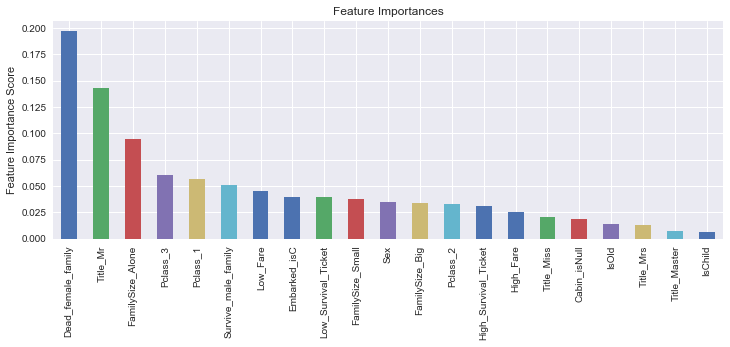

In [22]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train.columns]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train, predictors)

In [33]:
#Choose all predictors 
#search n_estimators First
from sklearn.grid_search import GridSearchCV 
predictors = [x for x in X_train.columns]
param_test1 = {'n_estimators':range(11,52,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               min_samples_split=5,
                                                               min_samples_leaf=5,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.92083, std: 0.01753, params: {'n_estimators': 11},
  mean: 0.92394, std: 0.01829, params: {'n_estimators': 16},
  mean: 0.92786, std: 0.01776, params: {'n_estimators': 21},
  mean: 0.92967, std: 0.01753, params: {'n_estimators': 26},
  mean: 0.93088, std: 0.01741, params: {'n_estimators': 31},
  mean: 0.93080, std: 0.01761, params: {'n_estimators': 36},
  mean: 0.93178, std: 0.01708, params: {'n_estimators': 41},
  mean: 0.93306, std: 0.01718, params: {'n_estimators': 46},
  mean: 0.93485, std: 0.01458, params: {'n_estimators': 51}],
 {'n_estimators': 51},
 0.9348466575229286)

In [35]:
#use n_estimators above
param_test2 = {'max_depth':range(1,16,2),
               'min_samples_split':range(2,20,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=51,
                                                               max_features='sqrt',
                                                               subsample=0.8, 
                                                               random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.89378, std: 0.01949, params: {'min_samples_split': 2, 'max_depth': 1},
  mean: 0.89378, std: 0.01949, params: {'min_samples_split': 4, 'max_depth': 1},
  mean: 0.89378, std: 0.01949, params: {'min_samples_split': 6, 'max_depth': 1},
  mean: 0.89378, std: 0.01949, params: {'min_samples_split': 8, 'max_depth': 1},
  mean: 0.89378, std: 0.01949, params: {'min_samples_split': 10, 'max_depth': 1},
  mean: 0.89378, std: 0.01949, params: {'min_samples_split': 12, 'max_depth': 1},
  mean: 0.89378, std: 0.01949, params: {'min_samples_split': 14, 'max_depth': 1},
  mean: 0.89378, std: 0.01949, params: {'min_samples_split': 16, 'max_depth': 1},
  mean: 0.89378, std: 0.01949, params: {'min_samples_split': 18, 'max_depth': 1},
  mean: 0.92791, std: 0.01544, params: {'min_samples_split': 2, 'max_depth': 3},
  mean: 0.92722, std: 0.01474, params: {'min_samples_split': 4, 'max_depth': 3},
  mean: 0.92831, std: 0.01415, params: {'min_samples_split': 6, 'max_depth': 3},
  mean: 0.92861, std: 0

In [39]:
param_test3 = {'min_samples_leaf':range(1,20,1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=51,
                                                               max_depth=5,
                                                               min_samples_split=12,
                                                               max_features='sqrt',
                                                               subsample=0.8, 
                                                               random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.93651, std: 0.01328, params: {'min_samples_leaf': 1},
  mean: 0.93207, std: 0.01563, params: {'min_samples_leaf': 2},
  mean: 0.93183, std: 0.01379, params: {'min_samples_leaf': 3},
  mean: 0.93192, std: 0.01430, params: {'min_samples_leaf': 4},
  mean: 0.93245, std: 0.01373, params: {'min_samples_leaf': 5},
  mean: 0.93015, std: 0.01641, params: {'min_samples_leaf': 6},
  mean: 0.93197, std: 0.01600, params: {'min_samples_leaf': 7},
  mean: 0.93181, std: 0.01727, params: {'min_samples_leaf': 8},
  mean: 0.93137, std: 0.01853, params: {'min_samples_leaf': 9},
  mean: 0.93105, std: 0.01775, params: {'min_samples_leaf': 10},
  mean: 0.93061, std: 0.01828, params: {'min_samples_leaf': 11},
  mean: 0.93077, std: 0.01701, params: {'min_samples_leaf': 12},
  mean: 0.92879, std: 0.01595, params: {'min_samples_leaf': 13},
  mean: 0.92934, std: 0.01629, params: {'min_samples_leaf': 14},
  mean: 0.92698, std: 0.01842, params: {'min_samples_leaf': 15},
  mean: 0.92558, std: 0.01716, par


Model Report
Accuracy : 0.9035
AUC Score (Train): 0.956348
CV Score : Mean - 0.9365076 | Std - 0.01328443 | Min - 0.9107378 | Max - 0.946843


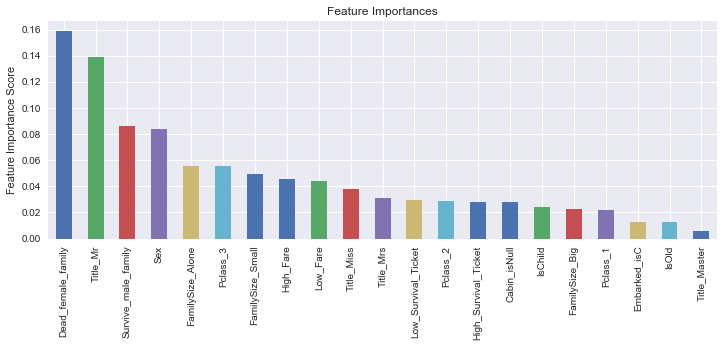

In [41]:
modelfit(gsearch3.best_estimator_, X_train, predictors)
#a little improve

In [42]:
param_test4 = {'max_features':range(7,21,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=51,
                                                               max_depth=5,
                                                               min_samples_split=12, 
                                                               min_samples_leaf=1, 
                                                               subsample=0.8, 
                                                               random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.93600, std: 0.01103, params: {'max_features': 7},
  mean: 0.93702, std: 0.01088, params: {'max_features': 9},
  mean: 0.93789, std: 0.01024, params: {'max_features': 11},
  mean: 0.93517, std: 0.01103, params: {'max_features': 13},
  mean: 0.93628, std: 0.01094, params: {'max_features': 15},
  mean: 0.93648, std: 0.01086, params: {'max_features': 17},
  mean: 0.93687, std: 0.01162, params: {'max_features': 19}],
 {'max_features': 11},
 0.9378887279609962)

In [43]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=51,
                                                               max_depth=5,
                                                               min_samples_split=12,
                                                               min_samples_leaf=1,
                                                               subsample=0.8,
                                                               random_state=10,
                                                               max_features=11),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.93646, std: 0.01160, params: {'subsample': 0.6},
  mean: 0.93779, std: 0.01181, params: {'subsample': 0.7},
  mean: 0.93660, std: 0.00967, params: {'subsample': 0.75},
  mean: 0.93789, std: 0.01024, params: {'subsample': 0.8},
  mean: 0.93700, std: 0.01105, params: {'subsample': 0.85},
  mean: 0.93742, std: 0.00995, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.9378887279609962)


Model Report
Accuracy : 0.9068
AUC Score (Train): 0.961397
CV Score : Mean - 0.9369762 | Std - 0.01108653 | Min - 0.9199605 | Max - 0.9493412


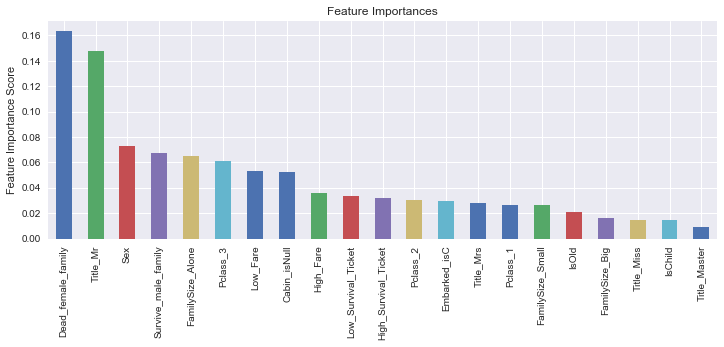

In [46]:
#decrease the learning rate to half, i.e. 0.05 with twice (102) the number of trees.
predictors = [x for x in X_train.columns]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, 
                                         n_estimators=102,
                                         max_depth=5,
                                         min_samples_split=12,
                                         min_samples_leaf=1, 
                                         subsample=0.8, 
                                         random_state=10, 
                                         max_features=11)
modelfit(gbm_tuned_1, X_train, predictors)


Model Report
Accuracy : 0.8979
AUC Score (Train): 0.954021
CV Score : Mean - 0.9383134 | Std - 0.01335783 | Min - 0.9152174 | Max - 0.9528986


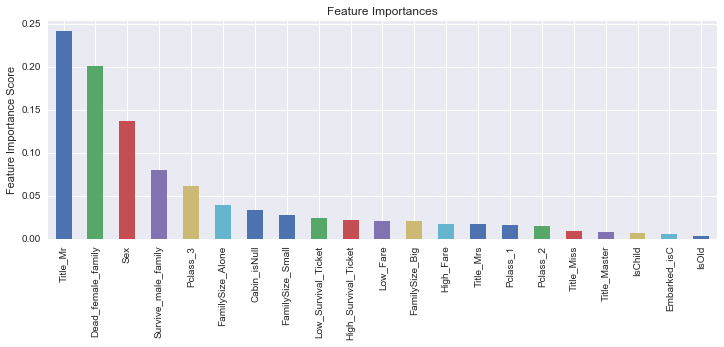

In [53]:
#decrease the learning rate to half, i.e. 0.05 with twice (102) the number of trees.
predictors = [x for x in X_train.columns]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.01, 
                                         n_estimators=200,
                                         max_depth=5,
                                         min_samples_split=12,
                                         min_samples_leaf=1, 
                                         subsample=0.8, 
                                         random_state=10, 
                                         max_features=11)
modelfit(gbm_tuned_1, X_train, predictors)

In [67]:
from sklearn.cross_validation import cross_val_score

def compute_score(model, X, y, scoring='accuracy'):
    xval = cross_val_score(model, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)
parameters={'n_estimators':51,
            'max_depth':5,
            'min_samples_split':12,
            'min_samples_leaf':1, 
            'random_state':10, 
            'max_features':11,
           'bootstrap': False}
model = RandomForestClassifier(**parameters)
model.fit(X_train, y_train)
compute_score(model,X_train, y_train, scoring='accuracy')

0.88662214557340691

In [65]:
y_test = model.predict( X_test )

passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': y_test.astype(np.int64) } )
#test.shape
#test.head()
test.to_csv( 'titanic_pred.csv' , index = False )


Model Report
Accuracy : 0.9012
AUC Score (Train): 0.959719
CV Score : Mean - 0.9371913 | Std - 0.01066414 | Min - 0.9166667 | Max - 0.9471128


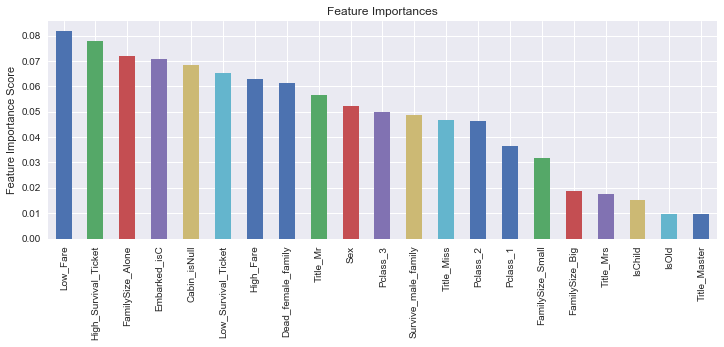